# DeepAR Time Series Forecasting

In [1]:

!pip install gluonts==0.12.*
!pip install mxnet
!pip uninstall numpy # Downgrade numpy to 1.23
!pip install numpy==1.23.1
!pip install optuna



ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 473, in run
    env = get_environment(lib_locations)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/metadata/__init__.py", line 86, in get_environment
    return select_backend().Environment.from_paths(paths)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/metadata/pkg_resources.py", line 263, in from_paths
    return cls(pkg_resources.WorkingSet(paths))
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 584, in __init__
    self.add_entry(entry)
  File "/usr/local/lib/python3.10

  Using cached optuna-4.0.0-py3-none-any.whl.metadata (16 kB)
Using cached optuna-4.0.0-py3-none-any.whl (362 kB)


# Load the Reatil Data from https://www.kaggle.com/datasets/manjeetsingh/retaildataset/data

In [1]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import numpy as np
import matplotlib.pyplot as plt
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [8]:
# import the 3 datasets and assign them to their own variable
features = pd.read_csv('/content/drive/MyDrive/MLData/Features data set.csv')
sales = pd.read_csv('/content/drive/MyDrive/MLData/sales data-set.csv')
stores = pd.read_csv('/content/drive/MyDrive/MLData/stores data-set.csv')

## Merge the three dataset


In [9]:
# merge the 3 separate datasets using the merge function.
features = features.merge(stores, on = 'Store')
df = features.merge(sales, on = ['Store','Date','IsHoliday'])
df['Date']=pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
#df = df.sort_values(by=['date_index','Store','Dept'])

In [10]:
# Only need these columns
df_1= df[['Store', 'Date', 'Temperature', 'Fuel_Price','CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size', 'Dept', 'Weekly_Sales', ]]
df_1=df_1.sort_values('Date')

In [11]:
df_1.head(5)

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,2010-02-05,42.31,2.572,211.096358,8.106,False,A,151315,1,24924.50
330761,35,2010-02-05,27.19,2.784,135.352461,9.262,False,B,103681,3,14612.19
330762,35,2010-02-05,27.19,2.784,135.352461,9.262,False,B,103681,4,26323.15
330763,35,2010-02-05,27.19,2.784,135.352461,9.262,False,B,103681,5,36414.63
330764,35,2010-02-05,27.19,2.784,135.352461,9.262,False,B,103681,6,11437.81


In [ ]:
df_1.tail(2)

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
390991,41,2012-10-26,41.80,3.686,199.219532,6.195,False,A,196321,4,32699.78
421569,45,2012-10-26,58.85,3.882,192.308899,8.667,False,B,118221,98,1076.80


# Build Train and Test dataset
__Set a Cutoff Date__

In [ ]:

CUTOFF_DATE='2012-01-01'
train = df_1[df_1['Date'] < CUTOFF_DATE]
test = df_1[df_1['Date'] >= CUTOFF_DATE]



In [ ]:
test.head(2)

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
253818,26,2012-01-06,22.94,3.439,136.698129,7.467,False,A,152513,48,117.00
253819,26,2012-01-06,22.94,3.439,136.698129,7.467,False,A,152513,49,1920.57


In [ ]:
train.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,2010-02-05,42.31,2.572,211.096358,8.106,False,A,151315,1,24924.50
330761,35,2010-02-05,27.19,2.784,135.352461,9.262,False,B,103681,3,14612.19
330762,35,2010-02-05,27.19,2.784,135.352461,9.262,False,B,103681,4,26323.15
330763,35,2010-02-05,27.19,2.784,135.352461,9.262,False,B,103681,5,36414.63
330764,35,2010-02-05,27.19,2.784,135.352461,9.262,False,B,103681,6,11437.81


# **UniVariate Prediction**

In [13]:
# pivot the data into the correct shape
storewide = df_1.pivot(index='Date', columns=['Store', 'Dept'], values='Weekly_Sales')
storewide = storewide.sort_index() # Sort the MultiIndex
storewide

Store             1         35                                          \
Dept              1         3         4         5         6         7    
Date                                                                     
2010-02-05  24924.50  14612.19  26323.15  36414.63  11437.81  23416.24   
2010-02-12  46039.49  12226.84  22103.33  46031.03  10336.07  24016.05   
2010-02-19  41595.55  11976.64  26684.51  43598.42  12919.52  27484.60   
2010-02-26  19403.54  10823.60  21240.59  27726.61   7849.31  21771.12   
2010-03-05  21827.90  11429.08  26119.02  25804.52   9630.80  24742.69   
...              ...       ...       ...       ...       ...       ...   
2012-09-28  18947.81   9424.06  19408.52  22758.85   2569.70  22335.42   
2012-10-05  21904.47   9260.87  18371.34  18202.05   3784.92  21777.38   
2012-10-12  22764.01   8263.79  18141.92  18186.89   4064.21  22188.19   
2012-10-19  24185.27   7959.58  16953.81  19518.18   3181.00  22073.41   
2012-10-26  27390.81   8319.50  19932.02  19590.53   2002.85  25195.73   

Store                                               ...  23     21  36  29  \
Dept              8         9         10        2   ...  99     99  71  99   
Date                                                ...                      
2010-02-05  27545.38  12454.61  15052.46  57523.15  ... NaN    NaN NaN NaN   
2010-02-12  23102.97  14416.53  14563.58  49657.69  ... NaN    NaN NaN NaN   
2010-02-19  26446.91  15878.00  16496.00  58388.44  ... NaN    NaN NaN NaN   
2010-02-26  20617.98   9672.11  17552.93  48306.46  ... NaN    NaN NaN NaN   
2010-03-05  27580.08  13610.69  18682.34  57248.20  ... NaN    NaN NaN NaN   
...              ...       ...       ...       ...  ...  ..    ...  ..  ..   
2012-09-28  19301.43   9909.01  14057.75  45028.96  ... NaN    NaN NaN NaN   
2012-10-05  20880.98  10399.06  14270.55  49505.75  ... NaN    NaN NaN NaN   
2012-10-12  21207.32   9649.81  14821.31  46110.32  ... NaN  29.88 NaN NaN   
2012-10-19  19478.71   9114.31  15732.96  45374.49  ... NaN    NaN NaN NaN   
2012-10-26  20084.18  13630.92  15071.72  46016.07  ... NaN    NaN NaN NaN   

Store          19   36  12  25    42    17  
Dept           39   49  99  96    24    99  
Date                                        
2010-02-05    NaN  NaN NaN NaN   NaN   NaN  
2010-02-12    NaN  NaN NaN NaN   NaN   NaN  
2010-02-19    NaN  NaN NaN NaN   NaN   NaN  
2010-02-26    NaN  NaN NaN NaN   NaN   NaN  
2010-03-05    NaN  NaN NaN NaN   NaN   NaN  
...           ...  ...  ..  ..   ...   ...  
2012-09-28  11.92  NaN NaN NaN   NaN   NaN  
2012-10-05  13.41  NaN NaN NaN  7.97  2.29  
2012-10-12  14.90  NaN NaN NaN   NaN   NaN  
2012-10-19   8.94  NaN NaN NaN  3.97   NaN  
2012-10-26  28.31  5.0 NaN NaN  7.97   NaN  

[143 rows x 3331 columns]

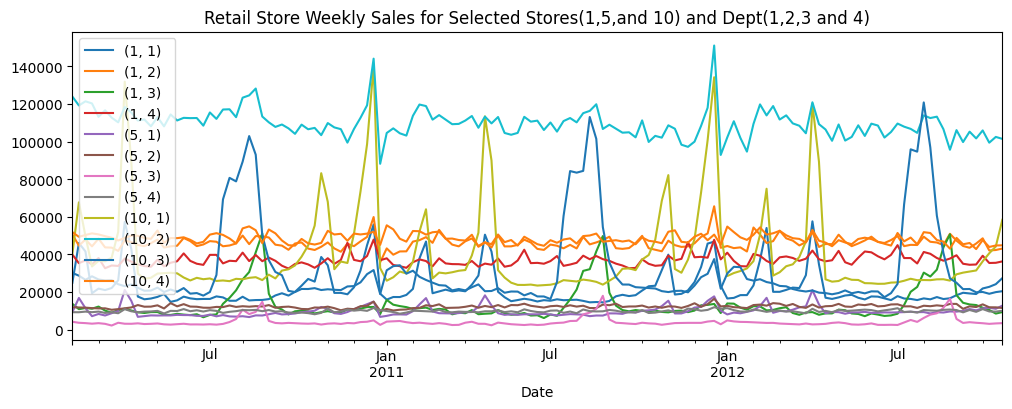

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have already created the 'storewide' DataFrame as described

# Sort the entire MultiIndex
storewide = storewide.sort_index()

# Select stores 1, 5, and 10
some_stores = storewide.loc[:, pd.IndexSlice[[1, 5, 10], [1,2,3,4]]]

# Plot the data for the selected stores
some_stores.plot(figsize=(12, 4))
plt.legend(loc='upper left')
plt.title("Retail Store Weekly Sales for Selected Stores(1,5,and 10) and Dept(1,2,3 and 4)")
plt.show()

In [ ]:
len_train = int(storewide.shape[0] * 0.8)
train_data = storewide[0:len_train]
test_data = storewide[len_train:]
[train_data.shape, test_data.shape]

[(114, 3331), (29, 3331)]

In [ ]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
def to_deepar_format(df, freq):
  # Reset the index to create a MultiIndex with 'Store' and 'Dept'
  data = []
  for store in df.columns.levels[0]: # Access 'Store' from the MultiIndex
        #print(store)
        for dept in df.columns.levels[1]: # Access 'Dept' from the MultiIndex
            try:
              df_subset = df[store][dept] # Select data for specific store and dept
            except KeyError:

                # Handle missing department for a specific store
                # Impute with the average sales of other departments in the same store
                df_subset = df[store].mean(axis=1)

            start_index = df_subset.index.min() # Access 'Date' from the DataFrame

            data.append(
                      {
                        FieldName.START:  start_index,
                        FieldName.TARGET:  df_subset.values,
                        FieldName.ITEM_ID: f"{store}_{dept}",
                     }

                    )
  #print(data)
  return ListDataset(data, freq=freq)

In [ ]:
train_data_lds = to_deepar_format(train_data, 'W')
test_data_lds = to_deepar_format(test_data, 'W')

In [120]:
# Calculate the mean of the 'target' values
mean_target = np.nanmean([item['target'] for item in train_data_lds])
# Impute missing values in both training and test datasets
for item in train_data_lds:
    item['target'] = np.nan_to_num(item['target'], nan=mean_target)

for item in test_data_lds:
    item['target'] = np.nan_to_num(item['target'], nan=mean_target)

In [ ]:
print(len(test_data_lds))
print(test_data_lds[0]['start']) # Check the start date of the first time series in your test data
print(len(test_data_lds[0]['target'])) # Check the length of the target array

3645
2012-04-09/2012-04-15
29


# Hyperparameter tuning

In [ ]:
import optuna
from gluonts.dataset.split import split
from gluonts.evaluation import Evaluator
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

def objective(trial):
    # Define hyperparameters to tune and their ranges
    num_layers = trial.suggest_int("num_layers", 1, 3)
    num_cells = trial.suggest_int("num_cells", 32, 128, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # Create estimator with trial hyperparameters
    estimator = DeepAREstimator(
        freq = 'W', # Replace with your frequency
        prediction_length = prediction_length, # Use your prediction length
        context_length = context_length, # Use your context length
        num_layers = num_layers,
        num_cells = num_cells,
        trainer = Trainer(
            epochs=5, # Consider increasing for better results
            learning_rate=learning_rate
        )
    )

    # Split data into training and validation sets
    training_data, validation_data = train_data_lds, test_data_lds

    # Train and evaluate the model
    predictor = estimator.train(training_data=training_data)

    # Generate forecasts
    forecasts = list(predictor.predict(validation_data))

    # Ensure forecasts have the correct format with 'start_date'
    # and convert predictions to pandas Series with date index
    forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data_lds,#
    predictor=predictor,
    num_samples=45,  # You can adjust the number of samples as needed
    )
    forecasts = list(forecast_it)
    tests = list(ts_it)
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) # Specify desired quantiles
    agg_metrics, item_metrics = evaluator(tests, forecasts)
    print(agg_metrics)
    return agg_metrics['wQuantileLoss[0.5]'] # Optimize for quantile loss

In [ ]:
#run the hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50) # Consider increasing trials for better results

# Get best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2024-09-25 13:15:59,989] A new study created in memory with name: no-name-ec532d94-0da1-4894-8932-07d4bdcdb10d
100%|██████████| 50/50 [00:04<00:00, 10.50it/s, epoch=5/5, avg_epoch_loss=7.88]
Running evaluation: 3645it [00:00, 30416.42it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: Use

{'MSE': 22017983.00130674, 'abs_error': 79712011.39137621, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 11.69277374838068, 'sMAPE': 0.28467739172838447, 'MSIS': inf, 'QuantileLoss[0.1]': 40236887.11389598, 'Coverage[0.1]': 0.13870116509005398, 'QuantileLoss[0.5]': 79712011.33631784, 'Coverage[0.5]': 0.6015976299486, 'QuantileLoss[0.9]': 49320580.7147443, 'Coverage[0.9]': 0.8818273543361727, 'RMSE': 4692.332362621678, 'NRMSE': 0.31986041976236734, 'ND': 0.14529195773601247, 'wQuantileLoss[0.1]': 0.07334021560787451, 'wQuantileLoss[0.5]': 0.14529195763565697, 'wQuantileLoss[0.9]': 0.08989716359732298, 'mean_absolute_QuantileLoss': 56423159.72165271, 'mean_wQuantileLoss': 0.10284311228028482, 'MAE_Coverage': 0.3939424514453909, 'OWA': nan}


100%|██████████| 50/50 [00:06<00:00,  8.11it/s, epoch=5/5, avg_epoch_loss=8.06]
Running evaluation: 3645it [00:00, 38490.80it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 21285248.42817453, 'abs_error': 77202452.99475522, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 14.040090852540756, 'sMAPE': 0.28752381246118924, 'MSIS': inf, 'QuantileLoss[0.1]': 40894324.32111251, 'Coverage[0.1]': 0.10418686741438064, 'QuantileLoss[0.5]': 77202452.9511651, 'Coverage[0.5]': 0.5560310949420297, 'QuantileLoss[0.9]': 50306858.24657676, 'Coverage[0.9]': 0.8859638736402405, 'RMSE': 4613.593873345868, 'NRMSE': 0.3144930833750651, 'ND': 0.1407177581124742, 'wQuantileLoss[0.1]': 0.07453853361864447, 'wQuantileLoss[0.5]': 0.140717758033022, 'wQuantileLoss[0.9]': 0.09169486247569408, 'mean_absolute_QuantileLoss': 56134545.17295146, 'mean_wQuantileLoss': 0.10231705137578685, 'MAE_Coverage': 0.3953212912134136, 'OWA': nan}


100%|██████████| 50/50 [00:03<00:00, 16.46it/s, epoch=5/5, avg_epoch_loss=7.83]
Running evaluation: 3645it [00:00, 42263.41it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 20653188.190180954, 'abs_error': 76278089.6078718, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 12.784775952774172, 'sMAPE': 0.28686236853883523, 'MSIS': inf, 'QuantileLoss[0.1]': 38434416.93845691, 'Coverage[0.1]': 0.07035683958082548, 'QuantileLoss[0.5]': 76278089.51016918, 'Coverage[0.5]': 0.5621115518161374, 'QuantileLoss[0.9]': 50764764.2708217, 'Coverage[0.9]': 0.910971413131907, 'RMSE': 4544.57788910928, 'NRMSE': 0.3097884972583446, 'ND': 0.13903291082540256, 'wQuantileLoss[0.1]': 0.07005483344301486, 'wQuantileLoss[0.5]': 0.13903291064731893, 'wQuantileLoss[0.9]': 0.09252949281007376, 'mean_absolute_QuantileLoss': 55159090.23981593, 'mean_wQuantileLoss': 0.10053907896680252, 'MAE_Coverage': 0.41097141313190705, 'OWA': nan}


100%|██████████| 50/50 [00:02<00:00, 21.26it/s, epoch=5/5, avg_epoch_loss=8.23]
Running evaluation: 3645it [00:00, 28721.53it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 26317690.747295745, 'abs_error': 82684978.76849869, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 24.901771898334843, 'sMAPE': 0.2925300491335981, 'MSIS': inf, 'QuantileLoss[0.1]': 47510535.598451264, 'Coverage[0.1]': 0.09623495176846146, 'QuantileLoss[0.5]': 82684978.78115979, 'Coverage[0.5]': 0.49600093061292355, 'QuantileLoss[0.9]': 53798727.792848274, 'Coverage[0.9]': 0.8866674853006422, 'RMSE': 5130.077070307594, 'NRMSE': 0.34969999529297663, 'ND': 0.1507108179926758, 'wQuantileLoss[0.1]': 0.08659797450465916, 'wQuantileLoss[0.5]': 0.15071081801575334, 'wQuantileLoss[0.9]': 0.09805953140928264, 'mean_absolute_QuantileLoss': 61331414.05748644, 'mean_wQuantileLoss': 0.11178944130989837, 'MAE_Coverage': 0.3955558284335474, 'OWA': nan}


100%|██████████| 50/50 [00:09<00:00,  5.26it/s, epoch=5/5, avg_epoch_loss=8.01]
Running evaluation: 3645it [00:00, 41855.88it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 24978019.2997714, 'abs_error': 87925532.64221992, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 13.695121245585844, 'sMAPE': 0.30051587858391965, 'MSIS': inf, 'QuantileLoss[0.1]': 42799384.94285853, 'Coverage[0.1]': 0.13218077728659738, 'QuantileLoss[0.5]': 87925532.70867456, 'Coverage[0.5]': 0.6645292791015895, 'QuantileLoss[0.9]': 53149855.79032758, 'Coverage[0.9]': 0.909303955401839, 'RMSE': 4997.80144661344, 'NRMSE': 0.3406832136054361, 'ND': 0.16026283303587388, 'wQuantileLoss[0.1]': 0.07801090851557511, 'wQuantileLoss[0.5]': 0.1602628331570015, 'wQuantileLoss[0.9]': 0.09687682529108628, 'mean_absolute_QuantileLoss': 61291591.14728689, 'mean_wQuantileLoss': 0.11171685565455429, 'MAE_Coverage': 0.40930395540183895, 'OWA': nan}


100%|██████████| 50/50 [00:04<00:00, 12.41it/s, epoch=5/5, avg_epoch_loss=7.79]
Running evaluation: 3645it [00:00, 40129.77it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 29662551.240055647, 'abs_error': 100829023.66276918, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 11.054537580726349, 'sMAPE': 0.3087631387016135, 'MSIS': inf, 'QuantileLoss[0.1]': 42595905.23132597, 'Coverage[0.1]': 0.14630252088364962, 'QuantileLoss[0.5]': 100829023.61531006, 'Coverage[0.5]': 0.7181367296887579, 'QuantileLoss[0.9]': 57351834.89666966, 'Coverage[0.9]': 0.9251802691397049, 'RMSE': 5446.33374299222, 'NRMSE': 0.37125814255538314, 'ND': 0.1837821676917233, 'wQuantileLoss[0.1]': 0.07764002381285484, 'wQuantileLoss[0.5]': 0.18378216760521907, 'wQuantileLoss[0.9]': 0.10453581871089491, 'mean_absolute_QuantileLoss': 66925587.91443523, 'mean_wQuantileLoss': 0.12198600337632293, 'MAE_Coverage': 0.42518026913970486, 'OWA': nan}


100%|██████████| 50/50 [00:09<00:00,  5.17it/s, epoch=5/5, avg_epoch_loss=7.94]
Running evaluation: 3645it [00:00, 26383.60it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 22658435.018148154, 'abs_error': 80647747.07631353, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 14.64945912028732, 'sMAPE': 0.29041897255423454, 'MSIS': inf, 'QuantileLoss[0.1]': 41977126.40186237, 'Coverage[0.1]': 0.13849096066909117, 'QuantileLoss[0.5]': 80647747.01430616, 'Coverage[0.5]': 0.5971774836633743, 'QuantileLoss[0.9]': 49676261.78248736, 'Coverage[0.9]': 0.8817285880557484, 'RMSE': 4760.087711182237, 'NRMSE': 0.32447907261065306, 'ND': 0.1469975334355199, 'wQuantileLoss[0.1]': 0.07651216885136167, 'wQuantileLoss[0.5]': 0.1469975333224984, 'wQuantileLoss[0.9]': 0.09054546738190941, 'mean_absolute_QuantileLoss': 57433711.7328853, 'mean_wQuantileLoss': 0.10468505651858984, 'MAE_Coverage': 0.3939095293519161, 'OWA': nan}


100%|██████████| 50/50 [00:03<00:00, 14.91it/s, epoch=5/5, avg_epoch_loss=7.85]
Running evaluation: 3645it [00:00, 41957.89it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 22009455.755863935, 'abs_error': 78648589.10552517, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 16.210216954750216, 'sMAPE': 0.29045847635772215, 'MSIS': inf, 'QuantileLoss[0.1]': 40445124.666582696, 'Coverage[0.1]': 0.10943196769916345, 'QuantileLoss[0.5]': 78648588.8460913, 'Coverage[0.5]': 0.5264208177347507, 'QuantileLoss[0.9]': 50884841.857063465, 'Coverage[0.9]': 0.8731357307856425, 'RMSE': 4691.4236384986525, 'NRMSE': 0.3197984751137413, 'ND': 0.14335364626808583, 'wQuantileLoss[0.1]': 0.07371977247986786, 'wQuantileLoss[0.5]': 0.14335364579521287, 'wQuantileLoss[0.9]': 0.09274835954396687, 'mean_absolute_QuantileLoss': 56659518.456579156, 'mean_wQuantileLoss': 0.10327392593968254, 'MAE_Coverage': 0.39104524359521425, 'OWA': nan}


100%|██████████| 50/50 [00:08<00:00,  6.01it/s, epoch=5/5, avg_epoch_loss=7.83]
Running evaluation: 3645it [00:00, 37414.23it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 19708210.37116129, 'abs_error': 74196890.93456295, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 9.765138532107505, 'sMAPE': 0.28637725933701674, 'MSIS': inf, 'QuantileLoss[0.1]': 37772078.093957454, 'Coverage[0.1]': 0.0670674155682974, 'QuantileLoss[0.5]': 74196891.06910428, 'Coverage[0.5]': 0.43583047447685896, 'QuantileLoss[0.9]': 47923753.87732194, 'Coverage[0.9]': 0.8618447428853072, 'RMSE': 4439.393018325962, 'NRMSE': 0.30261840053002914, 'ND': 0.13523948716936185, 'wQuantileLoss[0.1]': 0.06884758116419022, 'wQuantileLoss[0.5]': 0.1352394874145918, 'wQuantileLoss[0.9]': 0.0873511519952465, 'mean_absolute_QuantileLoss': 53297574.34679457, 'mean_wQuantileLoss': 0.09714607352467618, 'MAE_Coverage': 0.3872815809617691, 'OWA': nan}


100%|██████████| 50/50 [00:05<00:00,  8.93it/s, epoch=5/5, avg_epoch_loss=7.8]
Running evaluation: 3645it [00:00, 7530.40it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.

{'MSE': 18972738.09497558, 'abs_error': 73521532.89587241, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 3.8587527590597643, 'sMAPE': 0.28403482239816935, 'MSIS': inf, 'QuantileLoss[0.1]': 37115505.92964037, 'Coverage[0.1]': 0.04038891900443929, 'QuantileLoss[0.5]': 73521532.88585979, 'Coverage[0.5]': 0.3990265148333931, 'QuantileLoss[0.9]': 47053740.392577216, 'Coverage[0.9]': 0.8752017953957989, 'RMSE': 4355.770666021753, 'NRMSE': 0.2969181477255589, 'ND': 0.13400850466244296, 'wQuantileLoss[0.1]': 0.06765083987660403, 'wQuantileLoss[0.5]': 0.13400850464419284, 'wQuantileLoss[0.9]': 0.08576536887111162, 'mean_absolute_QuantileLoss': 52563593.06935912, 'mean_wQuantileLoss': 0.09580823779730284, 'MAE_Coverage': 0.39173393179859967, 'OWA': nan}


100%|██████████| 50/50 [00:04<00:00, 11.40it/s, epoch=5/5, avg_epoch_loss=7.76]
Running evaluation: 3645it [00:00, 42663.82it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 20326205.847712696, 'abs_error': 74879278.928918, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 7.626731222798302, 'sMAPE': 0.2807726438316589, 'MSIS': inf, 'QuantileLoss[0.1]': 39567341.74646714, 'Coverage[0.1]': 0.10431825180502428, 'QuantileLoss[0.5]': 74879278.95170581, 'Coverage[0.5]': 0.5251190200484732, 'QuantileLoss[0.9]': 48805023.74937559, 'Coverage[0.9]': 0.8713993572238723, 'RMSE': 4508.45936520589, 'NRMSE': 0.30732641969773455, 'ND': 0.13648328325360068, 'wQuantileLoss[0.1]': 0.07211982792063898, 'wQuantileLoss[0.5]': 0.1364832832951363, 'wQuantileLoss[0.9]': 0.08895745226003059, 'mean_absolute_QuantileLoss': 54417214.81584951, 'mean_wQuantileLoss': 0.09918685449193528, 'MAE_Coverage': 0.39046645240795747, 'OWA': nan}


100%|██████████| 50/50 [00:05<00:00,  9.55it/s, epoch=5/5, avg_epoch_loss=7.79]
Running evaluation: 3645it [00:00, 38397.90it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 19787246.19326081, 'abs_error': 74289113.52036437, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 7.848273431177414, 'sMAPE': 0.27834419799276633, 'MSIS': inf, 'QuantileLoss[0.1]': 36426336.26487145, 'Coverage[0.1]': 0.08938308082928893, 'QuantileLoss[0.5]': 74289113.67203352, 'Coverage[0.5]': 0.4939279203388551, 'QuantileLoss[0.9]': 48040584.713866934, 'Coverage[0.9]': 0.8604386541996771, 'RMSE': 4448.285758948138, 'NRMSE': 0.3032245885679664, 'ND': 0.1354075822883368, 'wQuantileLoss[0.1]': 0.06639468276729565, 'wQuantileLoss[0.5]': 0.1354075825647858, 'wQuantileLoss[0.9]': 0.08756410084284508, 'mean_absolute_QuantileLoss': 52918678.216923974, 'mean_wQuantileLoss': 0.09645545539164217, 'MAE_Coverage': 0.3868128847332257, 'OWA': nan}


100%|██████████| 50/50 [00:07<00:00,  6.39it/s, epoch=5/5, avg_epoch_loss=7.94]
Running evaluation: 3645it [00:00, 43694.91it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 25892025.459771354, 'abs_error': 82162498.85356706, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 21.026729968256827, 'sMAPE': 0.2894081719681886, 'MSIS': inf, 'QuantileLoss[0.1]': 45329551.367000625, 'Coverage[0.1]': 0.08644615721335298, 'QuantileLoss[0.5]': 82162498.7523911, 'Coverage[0.5]': 0.4357027378852775, 'QuantileLoss[0.9]': 50344423.91417331, 'Coverage[0.9]': 0.8724251628572616, 'RMSE': 5088.420723541967, 'NRMSE': 0.346860423086123, 'ND': 0.14975848811925885, 'wQuantileLoss[0.1]': 0.08262267061698034, 'wQuantileLoss[0.5]': 0.1497584879348443, 'wQuantileLoss[0.9]': 0.09176333383017998, 'mean_absolute_QuantileLoss': 59278824.677855015, 'mean_wQuantileLoss': 0.10804816412733487, 'MAE_Coverage': 0.39080838761908726, 'OWA': nan}


100%|██████████| 50/50 [00:04<00:00, 10.52it/s, epoch=5/5, avg_epoch_loss=7.82]
Running evaluation: 3645it [00:00, 38826.98it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 26981411.13930039, 'abs_error': 89416032.75908452, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 10.565595827439918, 'sMAPE': 0.300468710438684, 'MSIS': inf, 'QuantileLoss[0.1]': 44670962.38935006, 'Coverage[0.1]': 0.04222452542558363, 'QuantileLoss[0.5]': 89416032.93269318, 'Coverage[0.5]': 0.32717915698515343, 'QuantileLoss[0.9]': 51096412.50059934, 'Coverage[0.9]': 0.8449888572463528, 'RMSE': 5194.363400773996, 'NRMSE': 0.3540821769158651, 'ND': 0.16297958395214096, 'wQuantileLoss[0.1]': 0.08142225326160343, 'wQuantileLoss[0.5]': 0.16297958426857936, 'wQuantileLoss[0.9]': 0.09313399167722052, 'mean_absolute_QuantileLoss': 61727802.60754752, 'mean_wQuantileLoss': 0.11251194306913444, 'MAE_Coverage': 0.38166295241545095, 'OWA': nan}


100%|██████████| 50/50 [00:06<00:00,  7.23it/s, epoch=5/5, avg_epoch_loss=7.77]
Running evaluation: 3645it [00:00, 7324.66it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3

{'MSE': 29662631.02724031, 'abs_error': 99217911.45943671, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 19.268984003966988, 'sMAPE': 0.3066815927209975, 'MSIS': inf, 'QuantileLoss[0.1]': 35617604.20517866, 'Coverage[0.1]': 0.10610761388980083, 'QuantileLoss[0.5]': 99217911.60250074, 'Coverage[0.5]': 0.7175085235490878, 'QuantileLoss[0.9]': 57852444.02328773, 'Coverage[0.9]': 0.9437689441657696, 'RMSE': 5446.341067839978, 'NRMSE': 0.37125864186546975, 'ND': 0.18084557580213667, 'wQuantileLoss[0.1]': 0.06492059796896181, 'wQuantileLoss[0.5]': 0.18084557606290103, 'wQuantileLoss[0.9]': 0.10544828445849394, 'mean_absolute_QuantileLoss': 64229319.94365571, 'mean_wQuantileLoss': 0.11707148616345227, 'MAE_Coverage': 0.4437689441657697, 'OWA': nan}


100%|██████████| 50/50 [00:04<00:00, 12.16it/s, epoch=5/5, avg_epoch_loss=7.78]
Running evaluation: 3645it [00:00, 19808.93it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 28434100.00192546, 'abs_error': 98081099.14426145, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 11.796563755145291, 'sMAPE': 0.3099553930034248, 'MSIS': inf, 'QuantileLoss[0.1]': 45279081.66749482, 'Coverage[0.1]': 0.1602735912921098, 'QuantileLoss[0.5]': 98081099.14818034, 'Coverage[0.5]': 0.7373576403999684, 'QuantileLoss[0.9]': 56230972.67123985, 'Coverage[0.9]': 0.9288102639734034, 'RMSE': 5332.3634536596865, 'NRMSE': 0.3634891735716995, 'ND': 0.17877349552255042, 'wQuantileLoss[0.1]': 0.08253067894195482, 'wQuantileLoss[0.5]': 0.17877349552969343, 'wQuantileLoss[0.9]': 0.10249281083488668, 'mean_absolute_QuantileLoss': 66530384.49563833, 'mean_wQuantileLoss': 0.12126566176884497, 'MAE_Coverage': 0.42881026397340344, 'OWA': nan}


100%|██████████| 50/50 [00:09<00:00,  5.01it/s, epoch=5/5, avg_epoch_loss=7.94]
Running evaluation: 3645it [00:00, 38977.94it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 19554605.941754512, 'abs_error': 73880425.85180324, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 16.739118655332994, 'sMAPE': 0.2824625211038178, 'MSIS': inf, 'QuantileLoss[0.1]': 36783803.151174635, 'Coverage[0.1]': 0.037866487161019785, 'QuantileLoss[0.5]': 73880425.69257003, 'Coverage[0.5]': 0.494178059676296, 'QuantileLoss[0.9]': 48915006.32817706, 'Coverage[0.9]': 0.9115734060178505, 'RMSE': 4422.059016086795, 'NRMSE': 0.3014368002502732, 'ND': 0.13466266279086897, 'wQuantileLoss[0.1]': 0.067046241582965, 'wQuantileLoss[0.5]': 0.13466266250063286, 'wQuantileLoss[0.9]': 0.08915791871310329, 'mean_absolute_QuantileLoss': 53193078.39064058, 'mean_wQuantileLoss': 0.09695560759890039, 'MAE_Coverage': 0.4115734060178506, 'OWA': nan}


100%|██████████| 50/50 [00:03<00:00, 13.87it/s, epoch=5/5, avg_epoch_loss=7.68]
Running evaluation: 3645it [00:00, 34247.85it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 20361792.008025885, 'abs_error': 74893653.54852724, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 15.095699602087203, 'sMAPE': 0.2801160375879471, 'MSIS': inf, 'QuantileLoss[0.1]': 37905336.59378101, 'Coverage[0.1]': 0.09412801908392736, 'QuantileLoss[0.5]': 74893653.50720996, 'Coverage[0.5]': 0.48989950949827493, 'QuantileLoss[0.9]': 48167798.88029492, 'Coverage[0.9]': 0.8698289797275688, 'RMSE': 4512.404238100337, 'NRMSE': 0.30759532833472253, 'ND': 0.13650948403047586, 'wQuantileLoss[0.1]': 0.06909047289388534, 'wQuantileLoss[0.5]': 0.1365094839551664, 'wQuantileLoss[0.9]': 0.08779597549974373, 'mean_absolute_QuantileLoss': 53655596.32709529, 'mean_wQuantileLoss': 0.09779864411626515, 'MAE_Coverage': 0.38994299324252296, 'OWA': nan}


100%|██████████| 50/50 [00:06<00:00,  7.32it/s, epoch=5/5, avg_epoch_loss=7.73]
Running evaluation: 3645it [00:00, 7686.19it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3

{'MSE': 21104101.3359558, 'abs_error': 76537530.87362821, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 4.8894372111872695, 'sMAPE': 0.28758369698362146, 'MSIS': inf, 'QuantileLoss[0.1]': 36147786.78023383, 'Coverage[0.1]': 0.04795902461246376, 'QuantileLoss[0.5]': 76537530.83232702, 'Coverage[0.5]': 0.39868614548949644, 'QuantileLoss[0.9]': 46844164.84426391, 'Coverage[0.9]': 0.8621988657041566, 'RMSE': 4593.920040222271, 'NRMSE': 0.31315198474117967, 'ND': 0.1395057972669977, 'wQuantileLoss[0.1]': 0.0658869675654969, 'wQuantileLoss[0.5]': 0.13950579719171757, 'wQuantileLoss[0.9]': 0.08538337321980966, 'mean_absolute_QuantileLoss': 53176494.15227493, 'mean_wQuantileLoss': 0.0969253793256747, 'MAE_Coverage': 0.3873996219013855, 'OWA': nan}


100%|██████████| 50/50 [00:10<00:00,  4.78it/s, epoch=5/5, avg_epoch_loss=8.15]
Running evaluation: 3645it [00:00, 5583.25it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3

{'MSE': 30518948.7471843, 'abs_error': 101689301.1597026, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 21.32831045159099, 'sMAPE': 0.31399342911062744, 'MSIS': inf, 'QuantileLoss[0.1]': 52955896.66425415, 'Coverage[0.1]': 0.24403459725329213, 'QuantileLoss[0.5]': 101689301.28476006, 'Coverage[0.5]': 0.7530821145018675, 'QuantileLoss[0.9]': 53347310.14299108, 'Coverage[0.9]': 0.9191571378520232, 'RMSE': 5524.395781185875, 'NRMSE': 0.3765793675613156, 'ND': 0.1853502049240546, 'wQuantileLoss[0.1]': 0.09652329386393899, 'wQuantileLoss[0.5]': 0.1853502051519982, 'wQuantileLoss[0.9]': 0.09723672750608774, 'mean_absolute_QuantileLoss': 69330836.03066844, 'mean_wQuantileLoss': 0.12637007550734164, 'MAE_Coverage': 0.4191571378520233, 'OWA': nan}


100%|██████████| 50/50 [00:04<00:00, 11.25it/s, epoch=5/5, avg_epoch_loss=7.83]
Running evaluation: 3645it [00:00, 40642.59it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 22027202.448905267, 'abs_error': 82799049.36577275, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 7.332896806435738, 'sMAPE': 0.2912187162563377, 'MSIS': inf, 'QuantileLoss[0.1]': 39014655.24760398, 'Coverage[0.1]': 0.12028438199073119, 'QuantileLoss[0.5]': 82799049.3509464, 'Coverage[0.5]': 0.6340686723623231, 'QuantileLoss[0.9]': 51580537.10921024, 'Coverage[0.9]': 0.905515238892664, 'RMSE': 4693.314654794121, 'NRMSE': 0.3199273792959907, 'ND': 0.15091873572187087, 'wQuantileLoss[0.1]': 0.07111244017527368, 'wQuantileLoss[0.5]': 0.1509187356948467, 'wQuantileLoss[0.9]': 0.09401641091298538, 'mean_absolute_QuantileLoss': 57798080.56925354, 'mean_wQuantileLoss': 0.10534919559436857, 'MAE_Coverage': 0.4055152388926641, 'OWA': nan}


100%|██████████| 50/50 [00:08<00:00,  5.91it/s, epoch=5/5, avg_epoch_loss=7.81]
Running evaluation: 3645it [00:00, 32236.66it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 22086260.404168688, 'abs_error': 82720751.61479923, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 3.694546573404579, 'sMAPE': 0.3017385041649862, 'MSIS': inf, 'QuantileLoss[0.1]': 39601304.950671986, 'Coverage[0.1]': 0.05805044863686839, 'QuantileLoss[0.5]': 82720751.61466494, 'Coverage[0.5]': 0.30775579342598747, 'QuantileLoss[0.9]': 51955146.15381048, 'Coverage[0.9]': 0.7890076438356862, 'RMSE': 4699.6021538177765, 'NRMSE': 0.3203559768294864, 'ND': 0.15077602155211525, 'wQuantileLoss[0.1]': 0.07218173302557582, 'wQuantileLoss[0.5]': 0.15077602155187048, 'wQuantileLoss[0.9]': 0.09469921492866067, 'mean_absolute_QuantileLoss': 58092400.90638247, 'mean_wQuantileLoss': 0.10588565650203564, 'MAE_Coverage': 0.36300254794522874, 'OWA': nan}


100%|██████████| 50/50 [00:09<00:00,  5.49it/s, epoch=5/5, avg_epoch_loss=8.04]
Running evaluation: 3645it [00:00, 38013.33it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 23628019.843271542, 'abs_error': 82421978.19276059, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 18.861016355356437, 'sMAPE': 0.2928958448195306, 'MSIS': inf, 'QuantileLoss[0.1]': 42453345.25985193, 'Coverage[0.1]': 0.0669641531634477, 'QuantileLoss[0.5]': 82421978.31574613, 'Coverage[0.5]': 0.6142609325810383, 'QuantileLoss[0.9]': 57532437.99633231, 'Coverage[0.9]': 0.9239052149105059, 'RMSE': 4860.866161834899, 'NRMSE': 0.33134879858862093, 'ND': 0.15023144395772553, 'wQuantileLoss[0.1]': 0.07738017818872982, 'wQuantileLoss[0.5]': 0.1502314441818926, 'wQuantileLoss[0.9]': 0.10486500596216553, 'mean_absolute_QuantileLoss': 60802587.19064346, 'mean_wQuantileLoss': 0.11082554277759599, 'MAE_Coverage': 0.423905214910506, 'OWA': nan}


100%|██████████| 50/50 [00:08<00:00,  6.15it/s, epoch=5/5, avg_epoch_loss=7.87]
Running evaluation: 3645it [00:00, 20846.90it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 35055535.624915, 'abs_error': 110528381.11000004, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 11.351258597545916, 'sMAPE': 0.3169320624808739, 'MSIS': inf, 'QuantileLoss[0.1]': 51442741.48368115, 'Coverage[0.1]': 0.19667976056864944, 'QuantileLoss[0.5]': 110528381.79835096, 'Coverage[0.5]': 0.7444223137565289, 'QuantileLoss[0.9]': 57668046.45407274, 'Coverage[0.9]': 0.9239702602577383, 'RMSE': 5920.77153966567, 'NRMSE': 0.4035989618042386, 'ND': 0.2014612929288266, 'wQuantileLoss[0.1]': 0.09376524931448699, 'wQuantileLoss[0.5]': 0.20146129418349137, 'wQuantileLoss[0.9]': 0.10511218098593868, 'mean_absolute_QuantileLoss': 73213056.57870162, 'mean_wQuantileLoss': 0.13344624149463902, 'MAE_Coverage': 0.4239702602577384, 'OWA': nan}


100%|██████████| 50/50 [00:09<00:00,  5.44it/s, epoch=5/5, avg_epoch_loss=7.81]
Running evaluation: 3645it [00:00, 29545.57it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 26522091.06737252, 'abs_error': 93191787.27527034, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 5.1420435172411505, 'sMAPE': 0.30747714221265965, 'MSIS': inf, 'QuantileLoss[0.1]': 39503842.055046104, 'Coverage[0.1]': 0.12259616404237215, 'QuantileLoss[0.5]': 93191787.47281975, 'Coverage[0.5]': 0.7010805650355915, 'QuantileLoss[0.9]': 54764796.059808195, 'Coverage[0.9]': 0.9393629649141112, 'RMSE': 5149.960297650121, 'NRMSE': 0.35105536762224143, 'ND': 0.1698616931350812, 'wQuantileLoss[0.1]': 0.07200408633638894, 'wQuantileLoss[0.5]': 0.16986169349515667, 'wQuantileLoss[0.9]': 0.0998203946388414, 'mean_absolute_QuantileLoss': 62486808.52922469, 'mean_wQuantileLoss': 0.113895391490129, 'MAE_Coverage': 0.43936296491411125, 'OWA': nan}


100%|██████████| 50/50 [00:07<00:00,  6.47it/s, epoch=5/5, avg_epoch_loss=7.71]
Running evaluation: 3645it [00:00, 36320.32it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 21326372.639440306, 'abs_error': 77570849.7771242, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 8.904315719860907, 'sMAPE': 0.2912905406841638, 'MSIS': inf, 'QuantileLoss[0.1]': 38980078.08829289, 'Coverage[0.1]': 0.03433168503715241, 'QuantileLoss[0.5]': 77570849.8306674, 'Coverage[0.5]': 0.3697361729328219, 'QuantileLoss[0.9]': 47248587.07961489, 'Coverage[0.9]': 0.8754638324964604, 'RMSE': 4618.048574824685, 'NRMSE': 0.31479674530154766, 'ND': 0.14138923896962174, 'wQuantileLoss[0.1]': 0.07104941600762858, 'wQuantileLoss[0.5]': 0.14138923906721554, 'wQuantileLoss[0.9]': 0.08612051806536647, 'mean_absolute_QuantileLoss': 54599838.332858406, 'mean_wQuantileLoss': 0.09951972438007019, 'MAE_Coverage': 0.3918212774988202, 'OWA': nan}


100%|██████████| 50/50 [00:09<00:00,  5.13it/s, epoch=5/5, avg_epoch_loss=7.76]
Running evaluation: 3645it [00:00, 37231.54it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 23891270.047049377, 'abs_error': 82396500.9932845, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 4.8966953459038765, 'sMAPE': 0.29769360022231495, 'MSIS': inf, 'QuantileLoss[0.1]': 40621741.85399951, 'Coverage[0.1]': 0.03697129182138, 'QuantileLoss[0.5]': 82396501.02981076, 'Coverage[0.5]': 0.33380664586572867, 'QuantileLoss[0.9]': 48040805.178206205, 'Coverage[0.9]': 0.8562857304038962, 'RMSE': 4887.869683926667, 'NRMSE': 0.33318953731807216, 'ND': 0.1501850063867133, 'wQuantileLoss[0.1]': 0.07404169456515591, 'wQuantileLoss[0.5]': 0.15018500645329014, 'wQuantileLoss[0.9]': 0.08756450268561512, 'mean_absolute_QuantileLoss': 57019682.68733883, 'mean_wQuantileLoss': 0.10393040123468705, 'MAE_Coverage': 0.38542857680129866, 'OWA': nan}


100%|██████████| 50/50 [00:04<00:00, 11.04it/s, epoch=5/5, avg_epoch_loss=7.87]
Running evaluation: 3645it [00:00, 36748.28it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 47026567.69116823, 'abs_error': 134202724.8549389, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 16.921585152297958, 'sMAPE': 0.35006931875608377, 'MSIS': inf, 'QuantileLoss[0.1]': 57255296.41579508, 'Coverage[0.1]': 0.22170496643600698, 'QuantileLoss[0.5]': 134202725.06579497, 'Coverage[0.5]': 0.7911370465382811, 'QuantileLoss[0.9]': 66297612.65523781, 'Coverage[0.9]': 0.9531487716672903, 'RMSE': 6857.591974678008, 'NRMSE': 0.46745884094919965, 'ND': 0.2446127790195366, 'wQuantileLoss[0.1]': 0.1043598569626176, 'wQuantileLoss[0.5]': 0.2446127794038663, 'wQuantileLoss[0.9]': 0.12084138598145383, 'mean_absolute_QuantileLoss': 85918544.71227597, 'mean_wQuantileLoss': 0.15660467411597925, 'MAE_Coverage': 0.45314877166729034, 'OWA': nan}


100%|██████████| 50/50 [00:07<00:00,  7.09it/s, epoch=5/5, avg_epoch_loss=7.76]
Running evaluation: 3645it [00:00, 36944.53it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 23616202.781619154, 'abs_error': 86174251.01441394, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 9.809166052421991, 'sMAPE': 0.3256144393196761, 'MSIS': inf, 'QuantileLoss[0.1]': 46156822.47585845, 'Coverage[0.1]': 0.021633791938024744, 'QuantileLoss[0.5]': 86174251.00485103, 'Coverage[0.5]': 0.2700507213734727, 'QuantileLoss[0.9]': 48501364.30467029, 'Coverage[0.9]': 0.8589501082887325, 'RMSE': 4859.650479367745, 'NRMSE': 0.3312659296283275, 'ND': 0.15707075279840832, 'wQuantileLoss[0.1]': 0.08413054674363142, 'wQuantileLoss[0.5]': 0.1570707527809779, 'wQuantileLoss[0.9]': 0.08840396885851858, 'mean_absolute_QuantileLoss': 60277479.261793256, 'mean_wQuantileLoss': 0.10986842279437598, 'MAE_Coverage': 0.38631670276291086, 'OWA': nan}


100%|██████████| 50/50 [00:05<00:00,  8.39it/s, epoch=5/5, avg_epoch_loss=7.77]
Running evaluation: 3645it [00:00, 7235.04it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3

{'MSE': 19201260.72404307, 'abs_error': 72983859.10660101, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 6.359044769778833, 'sMAPE': 0.280456306059618, 'MSIS': inf, 'QuantileLoss[0.1]': 37310900.093538344, 'Coverage[0.1]': 0.04918796175409932, 'QuantileLoss[0.5]': 72983859.18820506, 'Coverage[0.5]': 0.4772283810643599, 'QuantileLoss[0.9]': 50644115.136167675, 'Coverage[0.9]': 0.8896888278942953, 'RMSE': 4381.924317470929, 'NRMSE': 0.2987009536490034, 'ND': 0.1330284807475649, 'wQuantileLoss[0.1]': 0.06800698696293887, 'wQuantileLoss[0.5]': 0.1330284808963055, 'wQuantileLoss[0.9]': 0.0923095843086188, 'mean_absolute_QuantileLoss': 53646291.47263703, 'mean_wQuantileLoss': 0.09778168405595439, 'MAE_Coverage': 0.3965629426314318, 'OWA': nan}


100%|██████████| 50/50 [00:04<00:00, 10.64it/s, epoch=5/5, avg_epoch_loss=7.75]
Running evaluation: 3645it [00:00, 37080.28it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 24178656.293363176, 'abs_error': 84315556.0266276, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 11.261735666189216, 'sMAPE': 0.29051966037825794, 'MSIS': inf, 'QuantileLoss[0.1]': 39003031.532276265, 'Coverage[0.1]': 0.09371983673130056, 'QuantileLoss[0.5]': 84315555.95689684, 'Coverage[0.5]': 0.5983194250390018, 'QuantileLoss[0.9]': 52140760.14511297, 'Coverage[0.9]': 0.90839209046881, 'RMSE': 4917.179709280837, 'NRMSE': 0.3351875025704297, 'ND': 0.15368288905120386, 'wQuantileLoss[0.1]': 0.07109125350181442, 'wQuantileLoss[0.5]': 0.15368288892410487, 'wQuantileLoss[0.9]': 0.095037535587101, 'mean_absolute_QuantileLoss': 58486449.211428694, 'mean_wQuantileLoss': 0.10660389267100677, 'MAE_Coverage': 0.40839209046881003, 'OWA': nan}


100%|██████████| 50/50 [00:04<00:00, 11.31it/s, epoch=5/5, avg_epoch_loss=7.83]
Running evaluation: 3645it [00:00, 19806.96it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 20188077.57617192, 'abs_error': 72191125.17859146, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 4.673749136819206, 'sMAPE': 0.29070415918856335, 'MSIS': inf, 'QuantileLoss[0.1]': 37954847.45390013, 'Coverage[0.1]': 0.0423625161499941, 'QuantileLoss[0.5]': 72191125.27038094, 'Coverage[0.5]': 0.4910658508321647, 'QuantileLoss[0.9]': 47837519.08181201, 'Coverage[0.9]': 0.9185561947687167, 'RMSE': 4493.11446283888, 'NRMSE': 0.3062804096257664, 'ND': 0.1315835559193761, 'wQuantileLoss[0.1]': 0.0691807168818407, 'wQuantileLoss[0.5]': 0.13158355608668182, 'wQuantileLoss[0.9]': 0.08719397088733183, 'mean_absolute_QuantileLoss': 52661163.935364366, 'mean_wQuantileLoss': 0.09598608128528478, 'MAE_Coverage': 0.4185561947687168, 'OWA': nan}


100%|██████████| 50/50 [00:05<00:00,  9.12it/s, epoch=5/5, avg_epoch_loss=7.77]
Running evaluation: 3645it [00:00, 32500.99it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 21378852.030662056, 'abs_error': 75416785.34777546, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 10.684682157594546, 'sMAPE': 0.27829389258645876, 'MSIS': inf, 'QuantileLoss[0.1]': 37797249.544112585, 'Coverage[0.1]': 0.06616516852407504, 'QuantileLoss[0.5]': 75416785.41671538, 'Coverage[0.5]': 0.4556555306996224, 'QuantileLoss[0.9]': 48186688.283557765, 'Coverage[0.9]': 0.8592427063106076, 'RMSE': 4623.727071385383, 'NRMSE': 0.3151838291978191, 'ND': 0.13746300210058893, 'wQuantileLoss[0.1]': 0.06889346144256053, 'wQuantileLoss[0.5]': 0.1374630022262465, 'wQuantileLoss[0.9]': 0.087830405422319, 'mean_absolute_QuantileLoss': 53800241.081461914, 'mean_wQuantileLoss': 0.098062289697042, 'MAE_Coverage': 0.3864142354368692, 'OWA': nan}


100%|██████████| 50/50 [00:04<00:00, 11.05it/s, epoch=5/5, avg_epoch_loss=7.81]
Running evaluation: 3645it [00:00, 22899.20it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 17966101.12404546, 'abs_error': 71445988.05123901, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 5.963259269391589, 'sMAPE': 0.2792583314413047, 'MSIS': inf, 'QuantileLoss[0.1]': 33335802.18585588, 'Coverage[0.1]': 0.07317808342940618, 'QuantileLoss[0.5]': 71445987.98716235, 'Coverage[0.5]': 0.5778780816479229, 'QuantileLoss[0.9]': 47316044.3764718, 'Coverage[0.9]': 0.9083037479862875, 'RMSE': 4238.643783575763, 'NRMSE': 0.2889340044702632, 'ND': 0.13022538630196084, 'wQuantileLoss[0.1]': 0.06076153239319011, 'wQuantileLoss[0.5]': 0.13022538618516763, 'wQuantileLoss[0.9]': 0.08624347322046597, 'mean_absolute_QuantileLoss': 50699278.183163345, 'mean_wQuantileLoss': 0.0924101305996079, 'MAE_Coverage': 0.4083037479862876, 'OWA': nan}


100%|██████████| 50/50 [00:03<00:00, 16.13it/s, epoch=5/5, avg_epoch_loss=7.83]
Running evaluation: 3645it [00:00, 34788.85it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 37995003.102861956, 'abs_error': 102762979.15491161, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 3.906355726068504, 'sMAPE': 0.3002448988093696, 'MSIS': inf, 'QuantileLoss[0.1]': 43715064.78372361, 'Coverage[0.1]': 0.046452292726543165, 'QuantileLoss[0.5]': 102762979.32547018, 'Coverage[0.5]': 0.32829096160224913, 'QuantileLoss[0.9]': 62243502.76477284, 'Coverage[0.9]': 0.802125839736069, 'RMSE': 6164.008687766586, 'NRMSE': 0.42017961515120034, 'ND': 0.18730720958595012, 'wQuantileLoss[0.1]': 0.0796799282080462, 'wQuantileLoss[0.5]': 0.1873072098968291, 'wQuantileLoss[0.9]': 0.11345191540379493, 'mean_absolute_QuantileLoss': 69573848.95798887, 'mean_wQuantileLoss': 0.12681301783622342, 'MAE_Coverage': 0.36737527991202307, 'OWA': nan}


100%|██████████| 50/50 [00:02<00:00, 18.84it/s, epoch=5/5, avg_epoch_loss=7.7]
Running evaluation: 3645it [00:00, 20290.14it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3

{'MSE': 20446747.558788113, 'abs_error': 76639683.62763429, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 8.407435372368797, 'sMAPE': 0.28948952265967065, 'MSIS': inf, 'QuantileLoss[0.1]': 38393469.811524265, 'Coverage[0.1]': 0.04772627594497083, 'QuantileLoss[0.5]': 76639683.62080741, 'Coverage[0.5]': 0.3818101121231632, 'QuantileLoss[0.9]': 48074727.39048639, 'Coverage[0.9]': 0.8604701164665891, 'RMSE': 4521.807996674352, 'NRMSE': 0.3082363507373103, 'ND': 0.1396919922125097, 'wQuantileLoss[0.1]': 0.06998019866549685, 'wQuantileLoss[0.5]': 0.13969199220006626, 'wQuantileLoss[0.9]': 0.08762633307412114, 'mean_absolute_QuantileLoss': 54369293.60760602, 'mean_wQuantileLoss': 0.09909950797989475, 'MAE_Coverage': 0.38682337215552964, 'OWA': nan}


100%|██████████| 50/50 [00:03<00:00, 14.21it/s, epoch=5/5, avg_epoch_loss=7.71]
Running evaluation: 3645it [00:00, 31205.96it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 28697736.833774243, 'abs_error': 95848846.62202999, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 10.860576980232967, 'sMAPE': 0.3004388823884911, 'MSIS': inf, 'QuantileLoss[0.1]': 43897054.842232615, 'Coverage[0.1]': 0.13138379681589557, 'QuantileLoss[0.5]': 95848846.54180881, 'Coverage[0.5]': 0.6847950403505959, 'QuantileLoss[0.9]': 54771172.53437717, 'Coverage[0.9]': 0.9270603384139539, 'RMSE': 5357.026865134638, 'NRMSE': 0.365170394878611, 'ND': 0.17470474435876726, 'wQuantileLoss[0.1]': 0.08001164348442331, 'wQuantileLoss[0.5]': 0.17470474421254722, 'wQuantileLoss[0.9]': 0.09983201710899878, 'mean_absolute_QuantileLoss': 64839024.639472865, 'mean_wQuantileLoss': 0.11818280160198975, 'MAE_Coverage': 0.4270603384139539, 'OWA': nan}


100%|██████████| 50/50 [00:04<00:00, 10.10it/s, epoch=5/5, avg_epoch_loss=7.77]
Running evaluation: 3645it [00:00, 24482.41it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 22876519.705103, 'abs_error': 80190840.00631297, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 23.029262945515583, 'sMAPE': 0.2898826010685676, 'MSIS': inf, 'QuantileLoss[0.1]': 39498234.88418752, 'Coverage[0.1]': 0.09246869467328021, 'QuantileLoss[0.5]': 80190840.05990434, 'Coverage[0.5]': 0.6047209730631247, 'QuantileLoss[0.9]': 51086659.106930226, 'Coverage[0.9]': 0.915787865214673, 'RMSE': 4782.940487305168, 'NRMSE': 0.3260368690322459, 'ND': 0.14616472390600166, 'wQuantileLoss[0.1]': 0.07199386608454503, 'wQuantileLoss[0.5]': 0.14616472400368322, 'wQuantileLoss[0.9]': 0.09311621405956892, 'mean_absolute_QuantileLoss': 56925244.68367403, 'mean_wQuantileLoss': 0.10375826804926573, 'MAE_Coverage': 0.4157878652146731, 'OWA': nan}


100%|██████████| 50/50 [00:02<00:00, 16.82it/s, epoch=5/5, avg_epoch_loss=7.73]
Running evaluation: 3645it [00:00, 33762.73it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 20682400.12043424, 'abs_error': 80125479.0834387, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 9.472641003942389, 'sMAPE': 0.2920239826109345, 'MSIS': inf, 'QuantileLoss[0.1]': 37275255.021543235, 'Coverage[0.1]': 0.08006601880058668, 'QuantileLoss[0.5]': 80125479.04295403, 'Coverage[0.5]': 0.645137250560531, 'QuantileLoss[0.9]': 51517494.46350064, 'Coverage[0.9]': 0.9310906367784675, 'RMSE': 4547.790685644431, 'NRMSE': 0.3100075027270387, 'ND': 0.146045589834761, 'wQuantileLoss[0.1]': 0.06794201629912784, 'wQuantileLoss[0.5]': 0.14604558976096915, 'wQuantileLoss[0.9]': 0.09390150239096813, 'mean_absolute_QuantileLoss': 56306076.175999306, 'mean_wQuantileLoss': 0.1026297028170217, 'MAE_Coverage': 0.4310906367784675, 'OWA': nan}


100%|██████████| 50/50 [00:02<00:00, 18.76it/s, epoch=5/5, avg_epoch_loss=7.73]
Running evaluation: 3645it [00:00, 35170.36it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 19002772.423734773, 'abs_error': 73067227.40683705, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 11.07335961779554, 'sMAPE': 0.2808355639414001, 'MSIS': inf, 'QuantileLoss[0.1]': 38247152.02117105, 'Coverage[0.1]': 0.07471419918509865, 'QuantileLoss[0.5]': 73067227.44216698, 'Coverage[0.5]': 0.5110130446991118, 'QuantileLoss[0.9]': 48105083.84255641, 'Coverage[0.9]': 0.8990589208622718, 'RMSE': 4359.216950753285, 'NRMSE': 0.29715306929454866, 'ND': 0.13318043706309363, 'wQuantileLoss[0.1]': 0.06971350362367124, 'wQuantileLoss[0.5]': 0.1331804371274899, 'wQuantileLoss[0.9]': 0.08768166411236979, 'mean_absolute_QuantileLoss': 53139821.10196481, 'mean_wQuantileLoss': 0.0968585349545103, 'MAE_Coverage': 0.39968630695409063, 'OWA': nan}


100%|██████████| 50/50 [00:02<00:00, 21.83it/s, epoch=5/5, avg_epoch_loss=7.68]
Running evaluation: 3645it [00:00, 22173.13it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 19116286.78427739, 'abs_error': 74306755.94846061, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 8.087701924447373, 'sMAPE': 0.28191426623393384, 'MSIS': inf, 'QuantileLoss[0.1]': 35783736.63333919, 'Coverage[0.1]': 0.08819226530866743, 'QuantileLoss[0.5]': 74306756.08889797, 'Coverage[0.5]': 0.571822873057441, 'QuantileLoss[0.9]': 48723684.99708389, 'Coverage[0.9]': 0.8955993651981304, 'RMSE': 4372.217604863394, 'NRMSE': 0.29803927989505297, 'ND': 0.1354397393355945, 'wQuantileLoss[0.1]': 0.06522340936851823, 'wQuantileLoss[0.5]': 0.1354397395915712, 'wQuantileLoss[0.9]': 0.08880919522380751, 'mean_absolute_QuantileLoss': 52938059.23977369, 'mean_wQuantileLoss': 0.09649078139463231, 'MAE_Coverage': 0.39853312173271016, 'OWA': nan}


100%|██████████| 50/50 [00:02<00:00, 19.71it/s, epoch=5/5, avg_epoch_loss=8.21]
Running evaluation: 3645it [00:00, 23639.84it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 24390965.298554502, 'abs_error': 81827959.53560044, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 22.559517643620968, 'sMAPE': 0.29639977142639135, 'MSIS': inf, 'QuantileLoss[0.1]': 46493914.389523685, 'Coverage[0.1]': 0.09596316953018894, 'QuantileLoss[0.5]': 81827959.63588579, 'Coverage[0.5]': 0.39498616381332424, 'QuantileLoss[0.9]': 51866182.227911085, 'Coverage[0.9]': 0.8469285743977103, 'RMSE': 4938.721018498059, 'NRMSE': 0.33665590073065754, 'ND': 0.14914871963395, 'wQuantileLoss[0.1]': 0.08474496787312634, 'wQuantileLoss[0.5]': 0.1491487198167412, 'wQuantileLoss[0.9]': 0.09453705940484206, 'mean_absolute_QuantileLoss': 60062685.41777352, 'mean_wQuantileLoss': 0.10947691569823652, 'MAE_Coverage': 0.3823095247992368, 'OWA': nan}


100%|██████████| 50/50 [00:02<00:00, 21.36it/s, epoch=5/5, avg_epoch_loss=7.93]
Running evaluation: 3645it [00:00, 22648.30it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 26692415.493771404, 'abs_error': 92168310.27028827, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 8.8363613734411, 'sMAPE': 0.2996236278911864, 'MSIS': inf, 'QuantileLoss[0.1]': 46390126.64010583, 'Coverage[0.1]': 0.17816987376070267, 'QuantileLoss[0.5]': 92168310.12075928, 'Coverage[0.5]': 0.7050782558939526, 'QuantileLoss[0.9]': 52058458.737191, 'Coverage[0.9]': 0.9120837373482876, 'RMSE': 5166.470312870423, 'NRMSE': 0.35218079949503794, 'ND': 0.16799619036886043, 'wQuantileLoss[0.1]': 0.08455579280353868, 'wQuantileLoss[0.5]': 0.16799619009631228, 'wQuantileLoss[0.9]': 0.0948875239078987, 'mean_absolute_QuantileLoss': 63538965.166018695, 'mean_wQuantileLoss': 0.11581316893591657, 'MAE_Coverage': 0.4120837373482877, 'OWA': nan}


100%|██████████| 50/50 [00:03<00:00, 13.91it/s, epoch=5/5, avg_epoch_loss=7.65]
Running evaluation: 3645it [00:00, 31757.01it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 20074420.55467705, 'abs_error': 74565685.74069642, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 12.263427665824668, 'sMAPE': 0.2828333561582331, 'MSIS': inf, 'QuantileLoss[0.1]': 38990342.15604388, 'Coverage[0.1]': 0.08825926180423534, 'QuantileLoss[0.5]': 74565685.64432453, 'Coverage[0.5]': 0.5018024899197739, 'QuantileLoss[0.9]': 48371561.65139696, 'Coverage[0.9]': 0.8793778254536632, 'RMSE': 4480.448700150137, 'NRMSE': 0.30541702744028787, 'ND': 0.1359116935087919, 'wQuantileLoss[0.1]': 0.07106812443653215, 'wQuantileLoss[0.5]': 0.1359116933331338, 'wQuantileLoss[0.9]': 0.08816737613824692, 'mean_absolute_QuantileLoss': 53975863.15058845, 'mean_wQuantileLoss': 0.0983823979693043, 'MAE_Coverage': 0.3931259418178878, 'OWA': nan}


100%|██████████| 50/50 [00:03<00:00, 15.23it/s, epoch=5/5, avg_epoch_loss=7.83]
Running evaluation: 3645it [00:00, 35388.87it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 21603661.908182573, 'abs_error': 79741894.71752812, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 10.898993083831437, 'sMAPE': 0.28726180297193227, 'MSIS': inf, 'QuantileLoss[0.1]': 38358744.89029855, 'Coverage[0.1]': 0.08366437109823353, 'QuantileLoss[0.5]': 79741894.80323853, 'Coverage[0.5]': 0.5777825814201476, 'QuantileLoss[0.9]': 51454152.244317874, 'Coverage[0.9]': 0.9082502610721304, 'RMSE': 4647.9739573477145, 'NRMSE': 0.3168366573699285, 'ND': 0.1453464264024592, 'wQuantileLoss[0.1]': 0.06991690517058877, 'wQuantileLoss[0.5]': 0.14534642655868452, 'wQuantileLoss[0.9]': 0.09378604783309452, 'mean_absolute_QuantileLoss': 56518263.97928498, 'mean_wQuantileLoss': 0.1030164598541226, 'MAE_Coverage': 0.40825026107213036, 'OWA': nan}


100%|██████████| 50/50 [00:02<00:00, 17.51it/s, epoch=5/5, avg_epoch_loss=7.6]
Running evaluation: 3645it [00:00, 30574.52it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3

{'MSE': 31208967.0959488, 'abs_error': 97502884.71612886, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 12.355396825472116, 'sMAPE': 0.31450303829947035, 'MSIS': inf, 'QuantileLoss[0.1]': 46092776.13078368, 'Coverage[0.1]': 0.02769738834553649, 'QuantileLoss[0.5]': 97502884.79850355, 'Coverage[0.5]': 0.2653836063668515, 'QuantileLoss[0.9]': 52684923.7503189, 'Coverage[0.9]': 0.8061899332622435, 'RMSE': 5586.4986436898735, 'NRMSE': 0.38081270956138547, 'ND': 0.17771957774042202, 'wQuantileLoss[0.1]': 0.08401380876776902, 'wQuantileLoss[0.5]': 0.17771957789056728, 'wQuantileLoss[0.9]': 0.09602938856068699, 'mean_absolute_QuantileLoss': 65426861.559868716, 'mean_wQuantileLoss': 0.11925425840634109, 'MAE_Coverage': 0.3687299777540812, 'OWA': nan}


100%|██████████| 50/50 [00:04<00:00, 12.41it/s, epoch=5/5, avg_epoch_loss=7.72]
Running evaluation: 3645it [00:00, 33206.93it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 20500918.91182659, 'abs_error': 80280230.66731228, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 11.282481427457661, 'sMAPE': 0.2907229292750237, 'MSIS': inf, 'QuantileLoss[0.1]': 38227512.18545633, 'Coverage[0.1]': 0.1490429829495085, 'QuantileLoss[0.5]': 80280230.67244323, 'Coverage[0.5]': 0.6526014321428784, 'QuantileLoss[0.9]': 48904425.10101056, 'Coverage[0.9]': 0.9001787739662519, 'RMSE': 4527.794044766898, 'NRMSE': 0.3086443993808488, 'ND': 0.1463276572445689, 'wQuantileLoss[0.1]': 0.06967770587963244, 'wQuantileLoss[0.5]': 0.1463276572539211, 'wQuantileLoss[0.9]': 0.08913863219425332, 'mean_absolute_QuantileLoss': 55804055.98630337, 'mean_wQuantileLoss': 0.10171466510926896, 'MAE_Coverage': 0.4001787739662519, 'OWA': nan}


100%|██████████| 50/50 [00:03<00:00, 13.82it/s, epoch=5/5, avg_epoch_loss=7.77]
Running evaluation: 3645it [00:00, 33422.47it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 23347994.742289763, 'abs_error': 81907272.05080625, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 6.49365026925976, 'sMAPE': 0.2971061524301311, 'MSIS': inf, 'QuantileLoss[0.1]': 39001909.434647426, 'Coverage[0.1]': 0.0594273973462686, 'QuantileLoss[0.5]': 81907272.14614639, 'Coverage[0.5]': 0.3232932966178116, 'QuantileLoss[0.9]': 51751550.20857573, 'Coverage[0.9]': 0.771369888521564, 'RMSE': 4831.9762770826765, 'NRMSE': 0.3293794728994727, 'ND': 0.14929328342560544, 'wQuantileLoss[0.1]': 0.07108920824215506, 'wQuantileLoss[0.5]': 0.14929328359938296, 'wQuantileLoss[0.9]': 0.09432811836549616, 'mean_absolute_QuantileLoss': 57553577.263123184, 'mean_wQuantileLoss': 0.10490353673567805, 'MAE_Coverage': 0.3571232961738547, 'OWA': nan}


100%|██████████| 50/50 [00:05<00:00,  8.47it/s, epoch=5/5, avg_epoch_loss=7.63]
Running evaluation: 3645it [00:00, 19554.95it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 24942049.604672145, 'abs_error': 88939355.43882379, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 20.777807866073427, 'sMAPE': 0.2982501564015043, 'MSIS': inf, 'QuantileLoss[0.1]': 40867065.61106162, 'Coverage[0.1]': 0.1547263599291818, 'QuantileLoss[0.5]': 88939355.30567107, 'Coverage[0.5]': 0.6866279003183765, 'QuantileLoss[0.9]': 51633385.00380967, 'Coverage[0.9]': 0.9150797892420467, 'RMSE': 4994.201598321011, 'NRMSE': 0.34043782412811147, 'ND': 0.16211073897056105, 'wQuantileLoss[0.1]': 0.07448884886876145, 'wQuantileLoss[0.5]': 0.1621107387278621, 'wQuantileLoss[0.9]': 0.0941127373503008, 'mean_absolute_QuantileLoss': 60479935.30684745, 'mean_wQuantileLoss': 0.1102374416489748, 'MAE_Coverage': 0.41507978924204675, 'OWA': nan}


100%|██████████| 50/50 [00:03<00:00, 14.36it/s, epoch=5/5, avg_epoch_loss=7.71]
Running evaluation: 3645it [00:00, 20722.79it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python

{'MSE': 20188357.21364836, 'abs_error': 76729387.91682, 'abs_target_sum': 548633335.4817103, 'abs_target_mean': 14669.937487444475, 'seasonal_error': 1454.511425021655, 'MASE': inf, 'MAPE': 7.374645671796311, 'sMAPE': 0.2848903350716102, 'MSIS': inf, 'QuantileLoss[0.1]': 34739702.33063749, 'Coverage[0.1]': 0.07438916332214392, 'QuantileLoss[0.5]': 76729387.94189663, 'Coverage[0.5]': 0.5401481112459948, 'QuantileLoss[0.9]': 49972473.09151164, 'Coverage[0.9]': 0.894423840742183, 'RMSE': 4493.145581176773, 'NRMSE': 0.30628253085756574, 'ND': 0.1398554972046133, 'wQuantileLoss[0.1]': 0.06332043659019623, 'wQuantileLoss[0.5]': 0.13985549725032073, 'wQuantileLoss[0.9]': 0.09108537498479721, 'mean_absolute_QuantileLoss': 53813854.454681925, 'mean_wQuantileLoss': 0.0980871029417714, 'MAE_Coverage': 0.3981412802473943, 'OWA': nan}
Best hyperparameters: {'num_layers': 2, 'num_cells': 40, 'learning_rate': 0.006697307125200279}


# Train the Univariate
__Apply the best Hyperparameters based on hyperparameter tuning__

## Best hyperparameters: {'num_layers': 2, 'num_cells': 40, 'learning_rate': 0.006697307125200279}

In [121]:
prediction_length = 11
context_length = 11
num_cells = 40
num_layers = 2
epochs= 10
freq="W"        #Frequency of the data is weekly
estimator =   DeepAREstimator(freq=freq,
                                context_length=context_length,
                                prediction_length=prediction_length,
                                num_layers=num_layers,
                                num_cells=num_cells,

                                trainer=Trainer(epochs=epochs, learning_rate=.007),
                               )  # For univariate time series)
predictor = estimator.train(train_data_lds)

100%|██████████| 50/50 [00:03<00:00, 15.75it/s, epoch=10/10, avg_epoch_loss=8.76]


In [118]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data_lds,#
    predictor=predictor,
    num_samples=45,  # You can adjust the number of samples as needed


)
forecasts = list(forecast_it)
tests = list(ts_it)
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) # Use the MultivariateEvaluator
# Calculate the number of unique time series based on 'ITEM_ID'


#agg_metrics, item_metrics = evaluator(iter(ts_it), iter(forecast_it))
agg_metrics, item_metrics = evaluator(tests, forecasts)
#print(len(forecasts))

Running evaluation: 3645it [00:00, 20559.65it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: conve

In [119]:
import json
print(json.dumps(agg_metrics, indent=4))
#print(item_metrics)

{
    "MSE": 25820234.628076874,
    "abs_error": 87490557.78542933,
    "abs_target_sum": 548633335.4817103,
    "abs_target_mean": 14669.937487444475,
    "seasonal_error": 1454.511425021655,
    "MASE": Infinity,
    "MAPE": 4.364118600796377,
    "sMAPE": 0.3216327756307973,
    "MSIS": Infinity,
    "QuantileLoss[0.1]": 51945982.9854322,
    "Coverage[0.1]": 0.00968557456652695,
    "QuantileLoss[0.5]": 87490557.66977891,
    "Coverage[0.5]": 0.24316581664465262,
    "QuantileLoss[0.9]": 45286300.397135064,
    "Coverage[0.9]": 0.8813425894113724,
    "RMSE": 5081.361493544508,
    "NRMSE": 0.3463792192634414,
    "ND": 0.15946999959200617,
    "wQuantileLoss[0.1]": 0.09468251312112243,
    "wQuantileLoss[0.5]": 0.1594699993812089,
    "wQuantileLoss[0.9]": 0.08254383659967152,
    "mean_absolute_QuantileLoss": 61574280.35078206,
    "mean_wQuantileLoss": 0.11223211636733428,
    "MAE_Coverage": 0.3937808631371242,
    "OWA": NaN
}


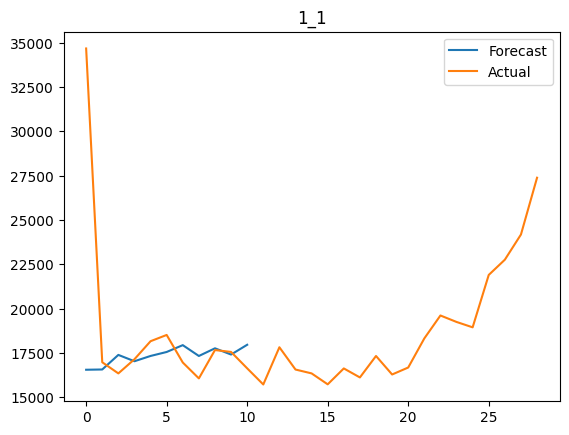

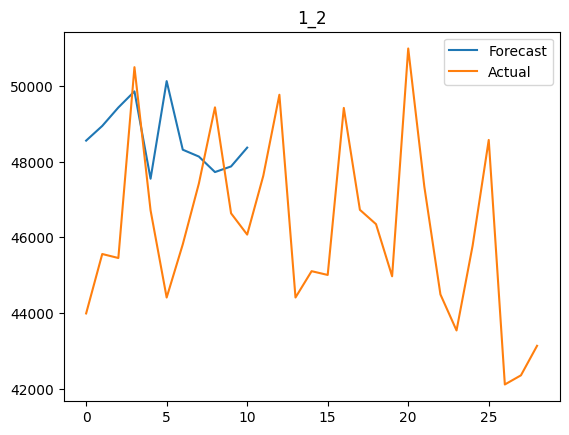

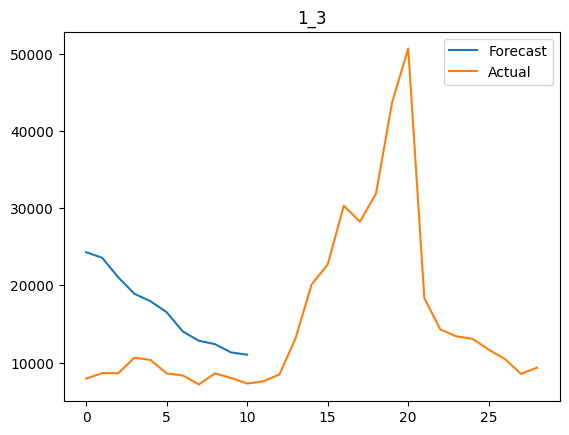

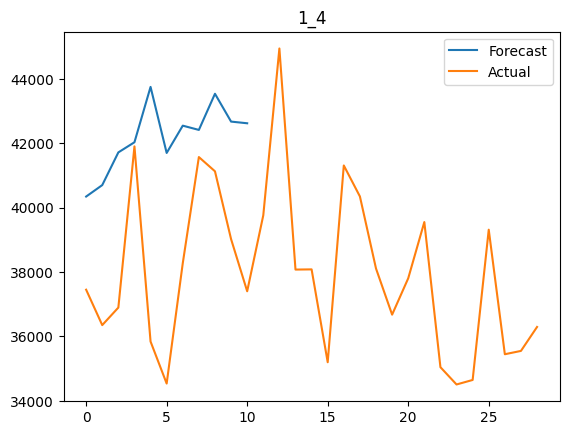

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

i=0
for forecast, test in zip(forecasts, tests):
    # Extract store and dept information from the test data
    i=i+1
    if i==5:
      break
    plt.plot(forecast.samples.mean(axis=0), label='Forecast')
    plt.plot(test.values, label='Actual')
    plt.title(str(forecast.item_id))  # Set title with store and dept
    plt.legend()
    plt.show()

# **Multivariate Prediction**

In [ ]:
# pivot the data into the correct shape
store_multi = df_1.pivot(index='Date', columns=['Store', 'Dept'], values=['Weekly_Sales', 'CPI', 'Size', 'Fuel_Price', 'Temperature', 'Unemployment', 'IsHoliday'])
store_multi = store_multi.sort_index() # Sort the MultiIndex
#store_multi.loc[:,(('Weekly_Sales',(1,1)))]
store_multi[('IsHoliday',1,1)]

,IsHoliday
,1
,1
Date,
2010-02-05,False
2010-02-12,True
2010-02-19,False
2010-02-26,False
2010-03-05,False
...,...
2012-09-28,False


**The .values attribute returns a NumPy array. Enclosing this in a list [] creates a 2D array (a list containing a NumPy array, so if you have one column then do not enclose []**

In [ ]:
len_multi_train = int(store_multi.shape[0] * 0.8)
train_multi_data = store_multi[0:len_multi_train]
test_multi_data = store_multi[len_multi_train:]
[train_multi_data.shape, test_multi_data.shape]

[(114, 23317), (29, 23317)]

In [ ]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
def to_deepar_format_multi(df, freq):
  df['Type']= df['Type'].map({'A':0, 'B':1})
  data = []
  for (store, dept), df_subset in df.groupby(["Store", "Dept"]): # Group by 'Store' and 'Dept'
            # Ensure date is in the right format
            df_subset.index = pd.to_datetime(df_subset['Date'], errors='coerce')

            # Check for any invalid dates
            if df_subset.index.isnull().any():
              raise ValueError(f"Invalid date found for store {store} and dept {dept}")
            if 'Weekly_Sales' not in df_subset.columns:
              raise ValueError(f"Weekly_Sales column not found for store {store} and dept {dept}")
            if "Size" not in df_subset.columns or 'Type' not in df_subset.columns:
              raise ValueError(f"Size or Type column not found for store {store} and dept {dept}")

            start_index = df_subset.index.min() # Access 'Date' from the DataFrame
            is_holiday = 1 if 'IsHoliday' in df_subset and df_subset["IsHoliday"].any() else 0  # Determine if there are any holidays for this store/dept combination
            df_subset.fillna(0, inplace=True)
            df_subset.fillna(df_subset.mean(), inplace=True)
            feat_static_real= np.concatenate([df_subset["Size"].values,df_subset["Type"].values])
            data.append({
                FieldName.START: start_index,
                FieldName.TARGET: df_subset["Weekly_Sales"].diff().values,  # Assuming "Weekly_Sales" is the target
                FieldName.ITEM_ID: f"{store}_{dept}",  # Add item_id
                FieldName.FEAT_STATIC_CAT: [int(store), int(dept), is_holiday],  # Store and Dept as static categorical features
                FieldName.FEAT_STATIC_REAL: feat_static_real ,
                FieldName.FEAT_DYNAMIC_REAL: [df_subset["CPI"].values, df_subset["Fuel_Price"].values,
                                                df_subset["Temperature"].values, df_subset["Unemployment"].values]
                # Add other features as needed
            })
    #print(data) # Debugging statement
  return ListDataset(data, freq=freq)
len_multi_train = int(df_1.shape[0] * 0.8)
train_multi_data = df_1.iloc[0:len_multi_train]
test_multi_data = df_1.iloc[len_multi_train:]
train_data_multi_lds = to_deepar_format_multi(train_multi_data, 'W')
test_data_multi_lds = to_deepar_format_multi(test_multi_data, 'W')

<ipython-input-78-63cc794f9344>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type']= df['Type'].map({'A':0, 'B':1})
<ipython-input-78-63cc794f9344>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type']= df['Type'].map({'A':0, 'B':1})


In [ ]:

prediction_length = 11
context_length = 11
num_cells = 100
num_layers = 2
epochs= 10
freq="W"        #Frequency of the data is weekly
estimator =   DeepAREstimator(freq=freq,
                                context_length=context_length,
                                prediction_length=prediction_length,
                                num_layers=num_layers,
                                num_cells=num_cells,
                                cardinality=[2],
                                trainer=Trainer(epochs=epochs, learning_rate=.008),
                               )  # For univariate time series)
predictor = estimator.train(train_data_multi_lds)

100%|██████████| 50/50 [00:05<00:00,  8.89it/s, epoch=10/10, avg_epoch_loss=8.04]


#Predict

In [ ]:
pred = list(predictor.predict(test_data_multi_lds))

In [ ]:
import numpy as np
all_preds = list()
for item in pred:

    family = item.item_id

    p = item.samples.mean(axis=0)
    p10 = np.percentile(item.samples, 10, axis=0)
    p90 = np.percentile(item.samples, 90, axis=0)
    dates = pd.date_range(start=item.start_date.to_timestamp(), periods=len(p), freq='D')
    family_pred = pd.DataFrame({'date': dates, 'family': family, 'pred': p, 'p10': p10, 'p90': p90})
    all_preds += [family_pred]
    #print(family_pred)
all_preds = pd.concat(all_preds, ignore_index=True)


In [ ]:

test_data=test_multi_data[['Store','Dept','Weekly_Sales', 'Date']]
test_data.reset_index(drop=False, inplace=True)
test_data.head()


,index,Store,Dept,Weekly_Sales,Date
0,410459,44,94,25314.10,2012-04-13
1,410444,44,60,432.00,2012-04-13
2,410445,44,67,1225.40,2012-04-13
3,410446,44,72,187.77,2012-04-13
4,410447,44,74,195.99,2012-04-13


In [ ]:

# Split the column
all_preds[['Store', 'Dept']] = all_preds['family'].str.split('_', expand=True)
#all_preds[['date','Store','Dept','pred']]

all_preds = all_preds.rename(columns={'date': 'date_index'})
all_preds.reset_index(drop=True, inplace=True)
# Convert 'col1' to integer
all_preds['Store'] = pd.to_numeric(all_preds['Store']).astype('Int64')
all_preds['Dept'] = pd.to_numeric(all_preds['Dept']).astype('Int64')
all_preds.head()


,date_index,family,pred,p10,p90,Store,Dept
0,2012-10-29,1_1,-672.754761,-5735.554492,4110.334155,1,1
1,2012-10-30,1_1,-2260.799316,-8887.616406,3092.829053,1,1
2,2012-10-31,1_1,-1543.293945,-5058.254736,1353.799890,1,1
3,2012-11-01,1_1,-176.203735,-2636.284741,2705.123999,1,1
4,2012-11-02,1_1,-1257.162231,-5100.400244,1433.011023,1,1


In [ ]:
# Inner join using 'left_on' and 'right_on' for different column names
merged_df = pd.merge(all_preds, test_data, left_on=['date_index', 'Store', 'Dept'], right_on=['Date', 'Store', 'Dept'], how='inner')
merged_df = merged_df.sort_values(by=['Store', 'Dept', 'date_index'], ascending=[True, True, True])
merged_df.head()


,date_index,family,pred,p10,p90,Store,Dept,index,Weekly_Sales,Date
0,2012-08-31,1_18,-664.354004,-5572.854736,3214.516064,1,18,9611,4.97,2012-08-31
1,2012-10-12,1_45,-5.728825,-94.737137,66.957760,1,45,10069,10.47,2012-10-12
2,2012-10-26,1_48,494.098511,-985.308282,2268.905908,1,48,10215,3341.00,2012-10-26
3,2012-10-12,1_54,8.561049,-37.548012,63.071626,1,54,10074,89.84,2012-10-12
4,2012-08-03,1_99,26.313208,-396.550949,403.037662,1,99,9379,20.00,2012-08-03


In [ ]:
merged_df

In [ ]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

print(wmape(merged_df['Weekly_Sales'], merged_df['pred']))

1.1469905608632682


<ipython-input-106-1e2aea8560d6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dept_data.sort_values(by='date_index', inplace=True)


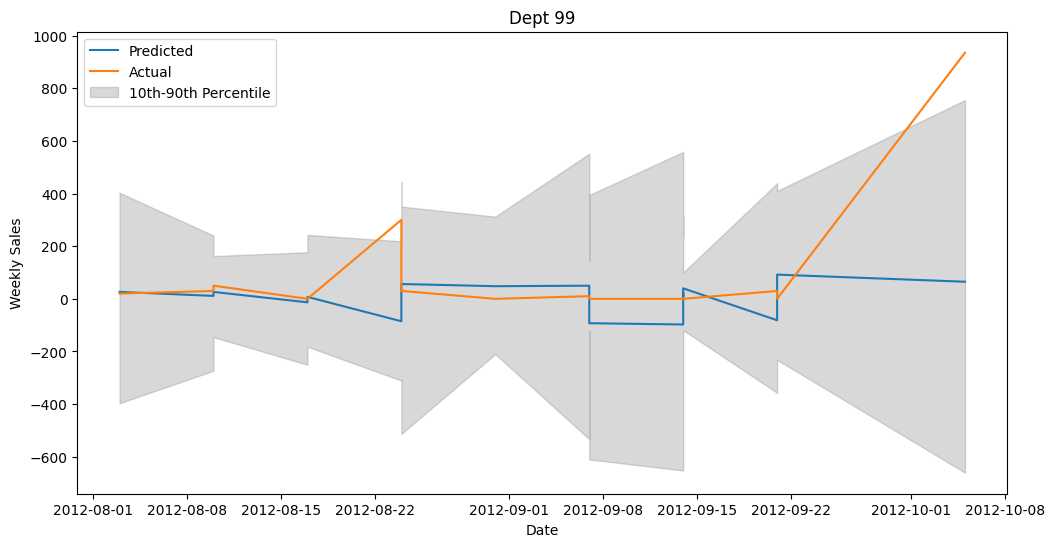

In [ ]:
def plot_dept(merged_df, dept):
    dept_data = merged_df[merged_df['Dept'] == dept]
    dept_data.sort_values(by='date_index', inplace=True)
    #dept_data.reset_index(drop=True, inplace=True)
    plt.figure(figsize=(12, 6))
    plt.plot(dept_data['date_index'], dept_data['pred'], label='Predicted')
    plt.plot(dept_data['date_index'], dept_data['Weekly_Sales'], label='Actual')
    plt.fill_between(dept_data['date_index'], dept_data['p10'], dept_data['p90'], color='gray', alpha=0.3, label='10th-90th Percentile')
    plt.title(f'Dept {dept}')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.show()
plot_dept(merged_df, dept=99)